## Librerías

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

## Data

In [16]:
# Time: 4 seconds
df_inmuebles = pd.read_csv('../Data/inmuebles_full.csv')

In [17]:
# Create the geometry of the point - from longitud and latitud columns
df_inmuebles['geometry'] = gpd.points_from_xy(x=df_inmuebles['longitud'], y=df_inmuebles['latitud'])

# Create a new variable precio por m2
df_inmuebles['precio_m2'] = df_inmuebles['precio'] / df_inmuebles['area']

# Make it a GeoDataFrame
df_inmuebles = gpd.GeoDataFrame(df_inmuebles, geometry='geometry')

# Filtrar filas sin habitaciones, al ser una de las variables claves no se analizan posibles imputaciones para no dañar la muestra
df_inmuebles = df_inmuebles[~df_inmuebles['habitaciones'].isna()]

# Habitaciones como entero
df_inmuebles['habitaciones'] = df_inmuebles['habitaciones'].astype('int64')

# Solo negocios de venta
df_inmuebles = df_inmuebles[df_inmuebles['tiponegocio'] == 'venta']

# Drop useless columns
df_inmuebles.drop(['latitud', 'longitud', 'fecha_creacion', 'direccion', 'tiponegocio'], axis=1, inplace=True)

# Filtrar las filas con 0 habitaciones y más de 10 habitaciones
df_inmuebles = df_inmuebles[(df_inmuebles['habitaciones'] >= 1) & ((df_inmuebles['habitaciones'] <= 10))]

# IQR Area
Q1 = df_inmuebles['area'].quantile(0.25)
Q2 = df_inmuebles['area'].quantile(0.50)
Q3 = df_inmuebles['area'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate the lower and upper whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Filtrar los inmuebles con menos de 20 m2 de area y con más de 296 m2 (+ 1.5 * IQR)
df_inmuebles = df_inmuebles[(df_inmuebles['area'] >= 20) & (df_inmuebles['area'] <= upper_whisker)]

# Filtrar los inmuebles con más de 4 garajes
df_inmuebles = df_inmuebles[(df_inmuebles['garajes'] >= 0) & (df_inmuebles['garajes'] <= 4)]

# IQR Precio
Q1 = df_inmuebles['precio'].quantile(0.25)
Q2 = df_inmuebles['precio'].quantile(0.50)
Q3 = df_inmuebles['precio'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate the lower and upper whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Filtrar los inmuebles con precio superior fuera del upper whisker
df_inmuebles = df_inmuebles[(df_inmuebles['precio'] <= upper_whisker)]

# Filtrar los inmuebles con precio m2 superior 10 millones
df_inmuebles= df_inmuebles[df_inmuebles['precio_m2'] <= 10e6]

In [18]:
df_inmuebles

,id,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad,tipo_inmueble,geometry,precio_m2
0,3669162,VALLE DEL CAUCA,CALI,3,2,81.0,2.640000e+08,0,1,12,apartamento,POINT (-76.49500 3.36400),3.259259e+06
1,3067524,ANTIOQUIA,SABANETA,2,3,90.0,4.600000e+08,1,2,4,apartamento,POINT (-75.60200 6.14300),5.111111e+06
2,3944108,CUNDINAMARCA,CAJICÁ,3,4,140.0,1.000000e+09,0,4,4,casa,POINT (-74.04343 4.89866),7.142857e+06
5,1556370,CUNDINAMARCA,ZIPAQUIRÁ,3,3,86.0,2.700000e+08,0,1,4,casa,POINT (-73.97115 5.01248),3.139535e+06
6,3732824,CUNDINAMARCA,CAJICÁ,3,4,196.0,8.300000e+08,0,4,4,casa,POINT (-74.03600 4.92500),4.234694e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
882878,3256721,CASANARE,YOPAL,3,2,92.0,2.300000e+08,0,1,4,apartamento,POINT (-72.39737 5.32763),2.500000e+06
882879,2808619,CASANARE,YOPAL,3,3,126.0,1.350000e+08,0,1,4,casa,POINT (-72.40322 5.31766),1.071429e+06
882881,1033723,CASANARE,YOPAL,2,2,37.0,1.400000e+08,0,1,4,casa,POINT (-72.41278 5.31848),3.783784e+06
882884,1599348,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",SAN ANDRÉS,2,2,65.0,4.650000e+08,1,1,12,apartamento,POINT (-81.68981 12.58286),7.153846e+06


In [19]:
df_inmuebles.columns

Index(['id', 'departamento', 'municipio', 'habitaciones', 'banos', 'area',
       'precio', 'num_ascensores', 'garajes', 'anos_antiguedad',
       'tipo_inmueble', 'geometry', 'precio_m2'],
      dtype='object')

## Preprocessing

In [20]:
# Handling categorical variables
categorical_features = ['departamento', 'municipio', 'tipo_inmueble']
numeric_features = ['habitaciones', 'banos', 'area', 'num_ascensores', 'garajes', 'anos_antiguedad']

# Separating features and target variable
X = df_inmuebles[categorical_features + numeric_features]
y = df_inmuebles['precio_m2']
# y = df_inmuebles['precio']


# Encoding categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## Create Pipeline

In [21]:
# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

## Train and Test Split

In [22]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((434980, 9), (108745, 9), (434980,), (108745,))

## Train the Model

In [24]:
# Training the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['habitaciones', 'banos',
                                                   'area', 'num_ascensores',
                                                   'garajes',
                                                   'anos_antiguedad']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['departamento', 'municipio',
                                                   'tipo_inmueble'])])),
                ('model', LinearRegression())])

## Predict

In [25]:
# Making predictions
y_pred_precio_m2 = pipeline.predict(X_test)

In [26]:
y_pred_precio = y_pred_precio_m2 * X_test['area']
y_test_precio = y_test * X_test['area']
# y_pred_precio = y_pred_precio_m2
# y_test_precio = y_test

## Evaluate

### Precio

In [13]:
# Evaluating the model
mse = mean_squared_error(y_test_precio, y_pred_precio)
rmse = root_mean_squared_error(y_test_precio, y_pred_precio)
mape = mean_absolute_percentage_error(y_test_precio, y_pred_precio)
r2 = r2_score(y_test_precio, y_pred_precio)

print(f'Mean Squared Error (MSE): {"{:,}".format(mse)}')
print(f'Root Mean Squared Error (RMSE): {"{:,}".format(rmse)}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 1.3480056905143916e+16
Root Mean Squared Error (RMSE): 116,103,647.25168592
Mean Absolute Percentage Error (MAPE): 0.23503281437348916%
R^2 Score: 0.7232614722894726


In [14]:
df_results = pd.DataFrame(
    {
        'y_test': y_test_precio,
        'y_pred': y_pred_precio,
    }
)
df_results.sort_values(by='y_test', ascending=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)

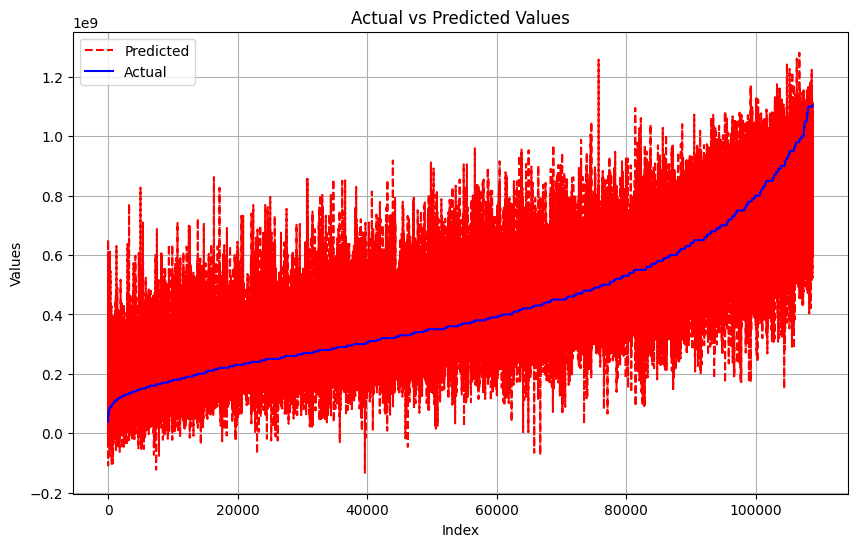

In [15]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_results.index, df_results['y_pred'], label='Predicted', color='r', linestyle='--')
plt.plot(df_results.index, df_results['y_test'], label='Actual', color='b')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

### Precio M2

In [27]:
# Evaluating the model
mse = mean_squared_error(y_test_precio, y_pred_precio)
rmse = root_mean_squared_error(y_test_precio, y_pred_precio)
mape = mean_absolute_percentage_error(y_test_precio, y_pred_precio)
r2 = r2_score(y_test_precio, y_pred_precio)

print(f'Mean Squared Error (MSE): {"{:,}".format(mse)}')
print(f'Root Mean Squared Error (RMSE): {"{:,}".format(rmse)}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 1.3399701473011294e+16
Root Mean Squared Error (RMSE): 115,757,079.58052196
Mean Absolute Percentage Error (MAPE): 0.2138555820718318%
R^2 Score: 0.7249111273419997


In [28]:
df_results = pd.DataFrame(
    {
        'y_test': y_test_precio,
        'y_pred': y_pred_precio,
    }
)
df_results.sort_values(by='y_test', ascending=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)

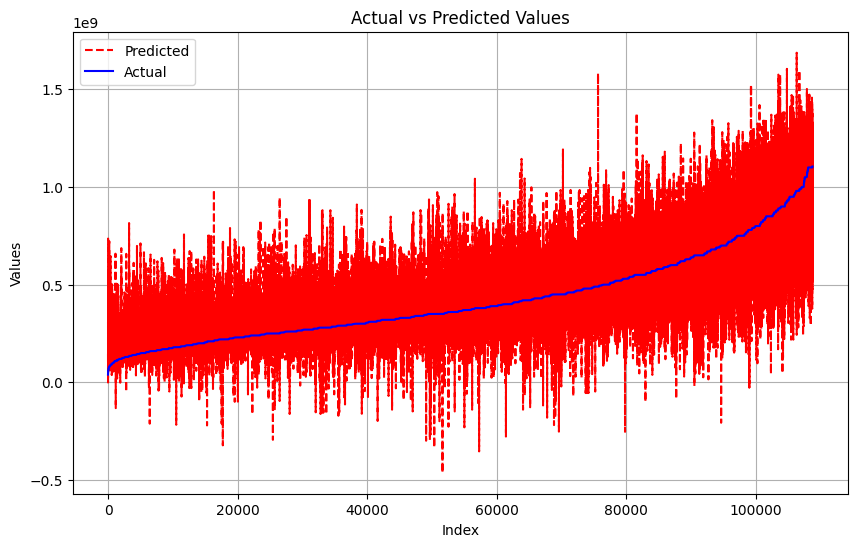

In [29]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_results.index, df_results['y_pred'], label='Predicted', color='r', linestyle='--')
plt.plot(df_results.index, df_results['y_test'], label='Actual', color='b')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()